In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D,Dropout,Flatten,Dense,Conv2D
import tensorflow as tf


# 9.1.1

## 9.1.1a

In [128]:
ACC   = pd.read_csv('acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [129]:
# Check 'timedelta' max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
# หา start_timedelta, end_timedelta
HeartR_max = HeartR['timedelta'].max()
HeartR_min = HeartR['timedelta'].min()

SleepL_max = SleepL['timedelta'].max()
SleepL_min = SleepL['timedelta'].min()

print(f'ACC start: {ACC_min_date} ACC end: {ACC_max_date}')
print(f'HeartR start: {HeartR_min} HeartR end: {HeartR_max}')
print(f'SleepL start: {SleepL_min} SLeepL end: {SleepL_max}')


ACC start: -124489.16105 ACC end: 17643.046417
HeartR start: -556410.36066 HeartR end: 16980.47229
SleepL start: 0 SLeepL end: 16980


In [130]:
 # select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน) #เลือกขอบ
ACC_new = ACC[(ACC['timedelta'] > SleepL_min) & (ACC['timedelta'] < SleepL_max)]
HeartR_new = HeartR[(HeartR['timedelta']> SleepL_min) & HeartR['timedelta']< SleepL_max]
SleepL_new = SleepL[(SleepL['timedelta']> SleepL_min) & SleepL['timedelta']< SleepL_max]

## 9.1.1b

In [131]:
 # Convert to datetime and round to second,
 # ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))
ACC_new

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7348\2630731856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))


,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


In [132]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()
ACC = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC = ACC.loc[:,~ACC.columns.duplicated()].copy() #ตัด duplicate columns(timedelta)
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


## 9.1.1c

In [133]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

In [134]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()

## 9.1.1d

In [135]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

In [136]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2.replace({-1:0},inplace=True)

## 9.1.1e

In [137]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')

In [138]:
# Fill NA
# Heart rate
# Fillna() # using median()
heart_mean = df.heartrate.mean()
df.heartrate.fillna(heart_mean,inplace=True)
# # Sleep Label
# Fillna() # with 0
df.sleep.fillna(0,inplace=True)
# # Drop column
df.drop(columns='timedelta',inplace=True)


In [139]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df[feature_columns])

df_feature = df[feature_columns]
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.788122
1,-0.581456,2.995094,0.757746,0.788122
2,-0.591075,3.024668,0.722696,0.788122
3,-0.599581,3.078699,0.674335,0.788122
4,-0.583998,3.109450,0.641889,0.788122
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630659
16977,-1.082531,-1.095348,1.137542,-0.630659
16978,-1.081511,-1.094296,1.138273,-0.630659
16979,-1.083260,-1.096440,1.137363,-0.630659


### Visualize

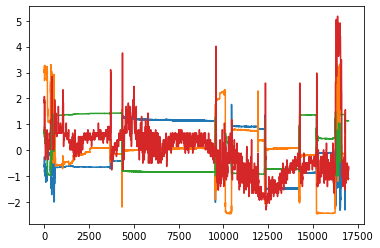

In [140]:
lst = [int(i) for i in range(len(df[feature_columns]))]
plt.plot(lst,df_feature.accX)
plt.plot(lst,df_feature.accY)
plt.plot(lst,df_feature.accZ)
plt.plot(lst,df_feature.heartrate)

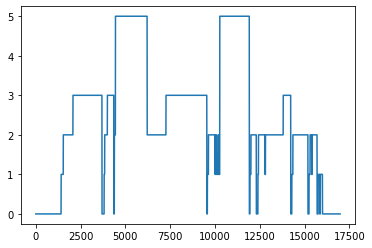

In [141]:
lst = [int(i) for i in range(len(df.heartrate))]
plt.plot(lst,df_label.sleep)

In [142]:
df_feature.info()
len(df_feature)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16981 entries, 0 to 16980
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   accX       16981 non-null  float64
 1   accY       16981 non-null  float64
 2   accZ       16981 non-null  float64
 3   heartrate  16981 non-null  float64
dtypes: float64(4)
memory usage: 663.3 KB


16981

# Create 3d input

In [159]:
# # ------------ 1D to 3D feature-------------------------------
# # set sliding window parameter
slidingW = 100
n_feature =4
stride_step = 5
df_feature3D = []
df_label_new = np.array([])                                         # ไม่ให้เกิน slicing window
for t in range( 0 , len(df_feature) - 96, stride_step):    # len(dataframe)ตัวสุดท้ายที่มากที่สุดที่ step หารลงตัว - (slidingW size - Stride Step) 
    F3d= df_feature[t:t+ slidingW]                         # = 16980 - (100-5)  = 16980 - 95 หรือ (16981 - 96)
    #print(F3d.shape)           # F3d เป็น  2D  (100,4)
    df_feature3D.append(np.array(F3d))    # list เก็บ 2D เป็น 3D (จำนวน 2D, มิติของ 2D) หรือ (3377,100,4)  # (จำนวน,กว้าง,สูง,จำนวนมิติของภาพ)
    #print(np.array(df_feature3D).shape)      
    Labels = stats.mode(df_label[t : t+slidingW])
    #print(Labels)
    df_label_new = np.append(df_label_new,Labels[0])
df_feature3D = np.array(df_feature3D).reshape(len(df_feature3D),100,4,1) # reshape ในรูปแบบ (Nset,slidingW,n_feature,1)

print(df_feature3D.shape)
print(df_label_new.shape)

(3377, 100, 4, 1)
(3377,)


## 9.1.2 Train Test Split

In [144]:
# # ------------ Train-Test-Split 2D features -------------------------------
x_train, x_test, y_train, y_test = train_test_split(df_feature, df_label)

In [145]:
# # ------------ Train-Test-Split 3D features -------------------------------
x3D_train, x3D_test, y3D_train, y3D_test = train_test_split( df_feature3D , df_label_new)

# 9.2 NN Model 

## 9.2.1 NN Model Train Test

In [146]:
# ------------ NN Architecture parameter -------------------------------
Hidden_Layer_param = (30, 30, 30)
mlp = MLPClassifier(hidden_layer_sizes = Hidden_Layer_param)
# View NN model parameters

In [147]:
# # ------------ Training NN using 1D features -------------------------------
y_train = np.array(y_train).ravel()  ## reshape เป็น (n_sample, ) แก้ตาม warning
y_train.shape
mlp.fit(x_train,y_train)
mlp_pred = mlp.predict(x_test)

### View Confusion Matrix and Classification Report

In [148]:
print('----- Confusion matrix of NN -----')
print(confusion_matrix(y_test,mlp_pred))
print('----- Classification matrix of NN -----')
print(classification_report(y_test,mlp_pred))

----- Confusion matrix of NN -----
[[ 632   50   43    8    3]
 [  16  150   49    3    3]
 [  24   86 1025   58   69]
 [   1    0   55 1142    0]
 [   0    2    1    0  826]]
----- Classification matrix of NN -----
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       736
         1.0       0.52      0.68      0.59       221
         2.0       0.87      0.81      0.84      1262
         3.0       0.94      0.95      0.95      1198
         5.0       0.92      1.00      0.95       829

    accuracy                           0.89      4246
   macro avg       0.84      0.86      0.85      4246
weighted avg       0.89      0.89      0.89      4246



# 9.3 CNN Model Train and Test

## 9.3.1 CNN Model Train Test

In [149]:
# ------------ CNN Architecture parameter -------------------------------
# Nlayer (CNN, dense), Nnode, Activation
CNN_L1 = 16 
CNN_L2 = 64
CNN_L3 = 128
D_L1 = 512
D_out = 6
Activation = "relu"
Ker_size = (3,3)
Pooling_size = (2,1)  
Input_shape = (slidingW, n_feature, 1)  # (100,4,1)
model = Sequential()

In [150]:
 # ------------ Create CNN Model -------------------------------
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Activation,input_shape=Input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=Pooling_size)) #ลดขนาดข้อมูล เพื่อให้ประมวลเร็ว
model.add(Dropout(0.4)) #ลดการเชื่อมต่อของ node เพื่อลด overfit
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation= Activation, padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation= Activation, padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Flatten())  # ลดมิติข้อมูล
model.add(Dense(D_L1 , activation= Activation )) #ออก 512 layerหลังก่อนส่งออก output layer
model.add(Dense(D_out, activation='sigmoid')) #ออก 6 layer
model.compile(optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 4, 16)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 50, 4, 16)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 4, 64)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 25, 4, 64)        

In [151]:

# ------------ Create Optimizer -------------------------------
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["acc"])

In [152]:
print(x3D_train.shape)
print(np.array(y3D_train).shape)
# np.array(y3D_train).reshape(2,4,1)
print(x3D_test.shape)
print(np.array(y3D_test).shape)

(2532, 100, 4, 1)
(2532,)
(845, 100, 4, 1)
(845,)


In [153]:
# ------ Train CNN using 3D feature--------------------------------------------
history = model.fit(x3D_train, y3D_train, epochs=50, batch_size=64,validation_data=(x3D_test, y3D_test))

Epoch 1/50


C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 [==============================] - 2s 48ms/step - loss: 1.0274 - acc: 0.5762 - val_loss: 0.6891 - val_acc: 0.7562
Epoch 2/50
40/40 [==============================] - 2s 43ms/step - loss: 0.6323 - acc: 0.7208 - val_loss: 0.5643 - val_acc: 0.7822
Epoch 3/50
40/40 [==============================] - 2s 43ms/step - loss: 0.5179 - acc: 0.7840 - val_loss: 0.4564 - val_acc: 0.8568
Epoch 4/50
40/40 [==============================] - 2s 43ms/step - loss: 0.4698 - acc: 0.8029 - val_loss: 0.3940 - val_acc: 0.8556
Epoch 5/50
40/40 [==============================] - 2s 43ms/step - loss: 0.4353 - acc: 0.8211 - val_loss: 0.3811 - val_acc: 0.8568
Epoch 6/50
40/40 [==============================] - 2s 43ms/step - loss: 0.3825 - acc: 0.8436 - val_loss: 0.3618 - val_acc: 0.8686
Epoch 7/50
40/40 [==============================] - 2s 42ms/step - loss: 0.3560 - acc: 0.8515 - val_loss: 0.3343 - val_acc: 0.8604
Epoch 8/50
40/40 [==============================] - 2s 42ms/step - loss: 0.3417 - acc: 0.8618 

In [154]:
# # ------- Test CNN -------------------------------
CNN_pred = np.argmax(model.predict(x3D_test),axis=1)

27/27 [==============================] - 0s 6ms/step


## 9.3.2 Performance of CNN Model

In [155]:
# ------------ View Confusion Matrix, Classification Report -------------------------------
print('----- Confusion matrix of NN -----')
print(confusion_matrix(y3D_test,CNN_pred))
print('----- Classification matrix of NN -----')
print(classification_report(y3D_test,CNN_pred))

----- Confusion matrix of NN -----
[[128   0   9   0   0]
 [  1  24   8   0   0]
 [  3   3 250   3   4]
 [  0   1  10 230   0]
 [  0   4   6   0 161]]
----- Classification matrix of NN -----
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       137
         1.0       0.75      0.73      0.74        33
         2.0       0.88      0.95      0.92       263
         3.0       0.99      0.95      0.97       241
         5.0       0.98      0.94      0.96       171

    accuracy                           0.94       845
   macro avg       0.91      0.90      0.91       845
weighted avg       0.94      0.94      0.94       845



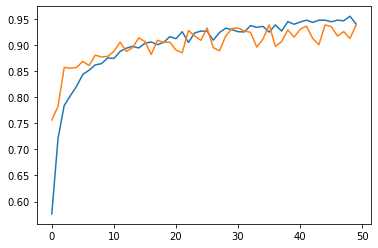

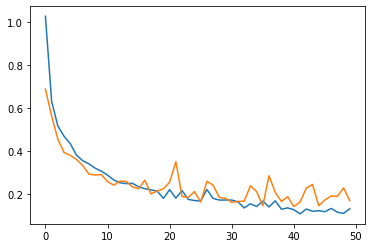

In [156]:
# ------------ View Confusion Matrix, Classification Report -------------------------------
# ------ View History Graph -------------------------------------------
# View Accuracy Graph
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()